# Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# from google.colab import files
# uploaded = files.upload()
# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

train_raw = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_Proj/train.csv')
test_raw = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_Proj/test.csv')
dev_raw = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_Proj/dev.csv')

# Data Columns

In [ ]:
train_raw.columns

Index(['id', 'count', 'hate_speech', 'offensive_language', 'neither', 'class',
       'tweet'],
      dtype='object')

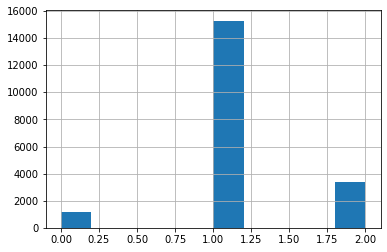

In [ ]:
train_raw['class'].hist()

# Feature Engineering

### 1 TFIDF

In [ ]:
!pip install transformers
!pip install emoji
from transformers import AutoTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

     |████████████████████████████████| 4.0 MB 5.1 MB/s 
     |████████████████████████████████| 880 kB 39.7 MB/s 
     |████████████████████████████████| 596 kB 57.6 MB/s 
     |████████████████████████████████| 6.6 MB 48.0 MB/s 
     |████████████████████████████████| 77 kB 6.1 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=e02e07800a4354953f9e732512e0e807d603227ebd379dcc29814ee5b92d95c8
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 175 kB 5.3 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=59c693149aa10951f5f0b75e6593583f9855c60b270e72786b292971d657f36a
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)
vectorizer = TfidfVectorizer(max_features=10000)

tfidfdata_train = train_raw.copy()
corpus_train = tfidfdata_train['tweet'].tolist()
normalized_corpus_train = [tokenizer.normalizeTweet(tweet) for tweet in corpus_train]

# this is the final feature, shape (n_examples, n_features), sparse row matrix format
tfidf_train = vectorizer.fit_transform(normalized_corpus_train).toarray() 

tfdif_vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in tfdif_vocab.values()} #keys are indices; values are IDF scores

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
tfidfdata_test = test_raw.copy()
corpus_test = tfidfdata_test['tweet'].tolist()
normalized_corpus_test = [tokenizer.normalizeTweet(tweet) for tweet in corpus_test]

tfidf_test = vectorizer.transform(normalized_corpus_test).toarray()

In [ ]:
tfidfdata_dev = dev_raw.copy()
corpus_dev = tfidfdata_dev['tweet'].tolist()
normalized_corpus_dev = [tokenizer.normalizeTweet(tweet) for tweet in corpus_dev]

tfidf_dev = vectorizer.transform(normalized_corpus_dev).toarray()

### 2 POS Tags

In [ ]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


True

In [ ]:
def reconstruct_sentence_to_tags(tweet):
    #returns a "reconstructed sentence" where each token is replaced by its Penn POS tag
    text = word_tokenize(tweet)
    word_tag_pairs = nltk.pos_tag(text)
    tags = []
    for word, tag in word_tag_pairs:
        tags.append(tag)
    reconstructed_sentence = " ".join(tags)
    return reconstructed_sentence

In [ ]:
#Append POS-tag-strings to original data
pos_tag_sentences_train = train_raw.apply(lambda row: reconstruct_sentence_to_tags(row.tweet), axis=1)
pos_tag_sentences_test = test_raw.apply(lambda row: reconstruct_sentence_to_tags(row.tweet), axis=1)
pos_tag_sentences_dev = dev_raw.apply(lambda row: reconstruct_sentence_to_tags(row.tweet), axis=1)

In [ ]:
pos_vectorizer = TfidfVectorizer(max_features=5000,min_df=5,max_df=0.75)
pos_train = pos_vectorizer.fit_transform(pos_tag_sentences_train).toarray()
pos_test = pos_vectorizer.transform(pos_tag_sentences_test).toarray()
pos_dev = pos_vectorizer.transform(pos_tag_sentences_dev).toarray()

pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### 3 Other Numerical Features

In [ ]:
!pip install vaderSentiment
!pip install textstat
import pandas as pd
import numpy as np
import pickle
import sys
import nltk
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *

     |████████████████████████████████| 125 kB 5.2 MB/s 
     |████████████████████████████████| 105 kB 5.4 MB/s 
     |████████████████████████████████| 2.0 MB 40.2 MB/s 


In [ ]:
sentiment_analyzer = VS()

In [ ]:
def sentiment_score(tweet):
  puncs = string.punctuation
  puncs = puncs.replace("&", "")
  tweet = tweet.replace('\n', ' ')  
  content = tweet.split()
  content_new = []
  for token in content:
      if (token[0] in puncs) or (token[0:4]=='http'):
          continue
      content_new.append(token)
  tweet_new = " ".join(content_new)

  sentiment = sentiment_analyzer.polarity_scores(tweet_new)
  return sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound']

In [ ]:
def tweet_obj(tweet):
    space = '\s+'
    url_format = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_format = '@[\w\-]+'
    hashtag_format = '#[\w\-]+'
    par_txt = re.sub(space, ' ', tweet)
    par_txt = re.sub(url_format, 'URL', par_txt)
    par_txt = re.sub(mention_format, 'MENTION', par_txt)
    par_txt = re.sub(hashtag_format, 'HASHTAG', par_txt)
    return par_txt.count('URL'),par_txt.count('MENTION'),par_txt.count('HASHTAG')

In [ ]:
def preprocess(tweet):
    space = '\s+'
    url_format = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_format = '@[\w\-]+'
    par_txt = re.sub(space, ' ', tweet)
    par_txt = re.sub(url_format, '', par_txt)
    par_txt = re.sub(mention_format, '', par_txt)
    return par_txt

In [ ]:
def num_features(tweet):
    tweet_processed = preprocess(tweet) 

    length = len(tweet_processed)
    count_chars = sum(len(w) for w in tweet_processed)
    count_terms = len(tweet.split())
    count_unique_terms = len(set(tweet_processed.split()))
    count_words = len(tweet_processed.split())
    
    count_syl = textstat.syllable_count(tweet_processed)
    avg_svl = round(float((count_syl+0.001))/float(length+0.001),4)
    
    retweet = 1 if "rt" in tweet_processed else 0

    return length, count_chars, count_terms, count_unique_terms, count_words, count_syl, avg_svl, retweet

In [ ]:
def quality(tweet):
    puncs = string.punctuation
    tweet = tweet.replace('\n', ' ')  
    content = tweet.split()
    content_new = []
    for token in content:
        if (token[0] in puncs) or (token[0:4]=='http'):
            continue
        content_new.append(token)
    tweet_new = " ".join(content_new)
    
    ease_score = textstat.flesch_reading_ease(tweet_new)
    grade_level = textstat.flesch_kincaid_grade(tweet_new)

    return ease_score, grade_level

In [ ]:
def collect_other_features(tweet):
    neg, pos, neu, compound = sentiment_score(tweet)
    url, mention, hashtag = tweet_obj(tweet)
    length, count_chars, count_terms, count_unique_terms, count_words, count_syl, avg_svl, retweet = num_features(tweet)
    ease_score, grade_level = quality(tweet)
    features = [neg, pos, neu, compound, url, mention, hashtag,
                length, count_chars, count_terms, count_unique_terms, count_words, 
                count_syl, avg_svl, retweet, ease_score, grade_level]
    return features

In [ ]:
def feature_matrix(tweets):
    features = []
    for t in tweets:
        features.append(collect_other_features(t))
    return np.array(features)

In [ ]:
other_features_names = ['sent_neg','sent_pos','sent_neu','sent_com','num_url','num_mention','num_hastag',
                            'length','count_chars','count_terms', 'count_unique_terms', 'count_words',
                            'count_syl', 'avg_svl', 'retweet', 'ease_score', 'grade_level']

tweets_train = train_raw.tweet
other_features_train = feature_matrix(tweets_train)
tweets_test = test_raw.tweet
other_features_test = feature_matrix(tweets_test)
tweets_dev = dev_raw.tweet
other_features_dev = feature_matrix(tweets_dev)

### Combine all features

In [ ]:
F_train = np.concatenate([tfidf_train,pos_train,other_features_train],axis=1)
F_test = np.concatenate([tfidf_test,pos_test,other_features_test],axis=1)
F_dev = np.concatenate([tfidf_dev,pos_dev,other_features_dev],axis=1)

In [ ]:
print(F_train.shape)
print(F_test.shape)
print(F_dev.shape)

(19826, 10049)
(2479, 10049)
(2478, 10049)


In [ ]:
tfdif_variables = ['']*len(tfdif_vocab)
for k,v in tfdif_vocab.items():
    tfdif_variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = tfdif_variables+pos_variables+other_features_names

In [ ]:
Features_train = pd.DataFrame(F_train,columns=feature_names)
Features_test = pd.DataFrame(F_test,columns=feature_names)
Features_dev = pd.DataFrame(F_dev,columns=feature_names)

In [ ]:
featured_train = pd.concat([train_raw, Features_train], axis=1)
featured_test = pd.concat([test_raw, Features_test], axis=1)
featured_dev = pd.concat([dev_raw, Features_dev], axis=1)

In [ ]:
featured_train.to_csv('/content/drive/My Drive/Colab Notebooks/ML_Proj/featured_train.csv')
featured_test.to_csv('/content/drive/My Drive/Colab Notebooks/ML_Proj/featured_test.csv')
featured_dev.to_csv('/content/drive/My Drive/Colab Notebooks/ML_Proj/featured_dev.csv')

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_Proj/Data/featured_train.csv')